# Hedwig: Sensor Inteligente para Casa Conectada

Neste tutorial, uma solução para aprendizado de atividade diária em ambiente de casa conectada é apresentado em 6 etapas:

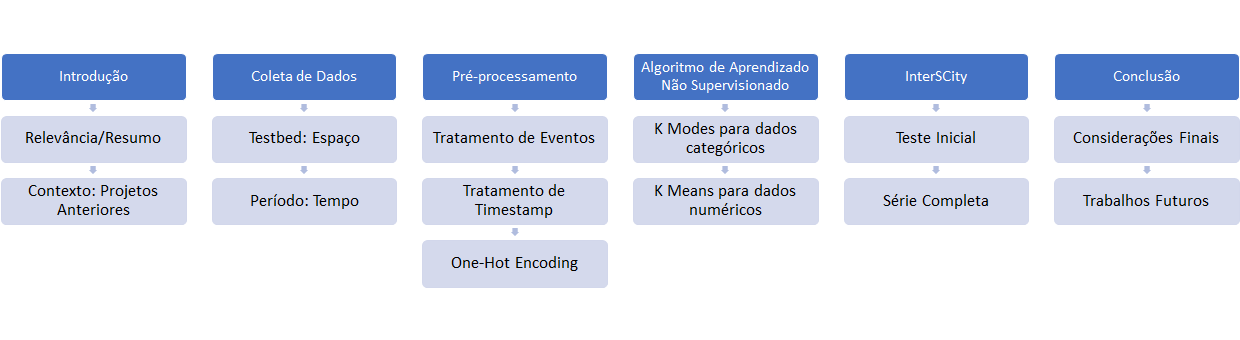

Na **introdução**, será apresentada a relevância e uma visão geral da solução.

A **coleta de dados** apresenta o contexto da infraestrutura de Internet das Coisas que permitiu a coleta de dados.

No **pré-processamento dos dados**, o filtro de eventos mais frequentes, obtenção de parâmetros a partir das séries temporais de eventos, e o one-hot endoding são apresentados.

Dois modelos de **algoritmos de aprendizado não-supervisionado** foram desenvolvidos: K Modes para processar diretamente dados categóricos, e K Means para processar os dados obtidos com o one-hot encoding.

Após a comparação entre os dois modelos, um deles foi escolhido para a rotulagem dos dados. Após um teste inicial com a API, os dados rotulados foram enviados para a plataforma **InterSCity**.

A última seção de **conclusão** apresenta as considerações finais e oportunidades de trabalhos futuros.

## 1. Introdução

Uma visão geral do projeto é descrita a partir de respostas a 6 perguntas.

Em especial, a última pergunta destaca a diferença entre este projeto e os projetos anteriores de casa conectada.

### 1.1. **Por que é relevante?**

Sensor inteligente para reconhecimento de atividade diária em uma casa conectada a partir de
dados de consumo energético, sensores de movimento e de estado da lâmpada. A capacidade
de reconhecer comportamento humano no ambiente residencial possui aplicações diversas:
monitoramento de idosos, autenticação continuada em local confiável, e informação
contextual para melhorar o engajamento de assistentes conversacionais.

### 1.2. Qual serão os dados de API ou interface que serão usados para troca de informações utilizando conceitos de IoT?

Serão utilizados dados disponíveis em medidor inteligente de energia, e módulos de automação residencial instalados em uma residência na região do ABC. Os dois tipos de módulos são baseados no ESP8266, e possuem autonomia de armazenamento de dados de um mês nos seus respectivos sistemas de arquivos. Vide exemplos de [dados de consumo energético coletados em trabalho anterior](https://github.com/vthayashi/OKIoT/tree/master/BoaEnergia), e [dados de estado de lâmpada e movimento na casa](https://github.com/vthayashi/OKIoT/tree/master/BrazilTestbed).

### 1.3. Descreva o que é entrada (sensores/dados) e o que é saída (dados/informações)

**Entrada**: dados de um mês (17/09 a 17/10) de 10 sensores de movimento PIR, 10 sensores de estado da lâmpada, e 8 sensores de corrente não-invasivo (consumo total e 4 setores) armazenados em módulos instalados em uma casa conectada.

**Saída**: atividade diária atual no InterSCity para consumo por outras aplicações de computação em nuvem (alertas em aplicações mobile, monitoramento de médio e longo prazo
de comportamento)

### 1.4. Descreva o filtro que será aplicado nos dados, pois o dado de entrada não deve ser igual à informação da saída

Será aplicado o algoritmo de aprendizado não-supervisionado K-means para aprendizado de atividades diárias. Os hiperparâmetros considerados serão relacionados à localização do evento e aspecto temporal do evento, como ambiente/setor (sala, cozinha, quarto, chuveiro, etc), dia da semana, período do dia e hora.

### 1.5. Descreva como será a comunicação. Se será por meio de alguma API ou outra tecnologia

Os dados disponíveis nos módulos instalados em residência da região do ABC serão coletados a partir de requests HTTP, armazenados no GitHub para facilitar a replicação do experimento. Um notebook no ambiente cloud Google Colab será desenvolvido para coletar os dados do Google Drive, executar os algoritmos de aprendizado não-supervisionado, e obter a atividade diária correspondente a um determinado instante. Esta informação será publicada no InterSCity, onde outras aplicações podem consumir a informação.

### 1.6. **Diferença entre projetos anteriores e este**

Nos projetos anteriores, implementei módulos de automação residencial com ESP8266, e módulo coletor de dados baseado no sistema de arquivos do ESP8266, com instalação de 10 módulos com sensores PIR e de estado da iluminação principal com comunicação RF 433 MHz para um módulo coletor de dados (autonomia de armazenamento de dados de um mês) em uma residência na região do ABC.

Em trabalho anterior, já fiz predição de eventos reais com LSTM e classificação de pessoa na residência (algoritmo de aprendizado supervisionado Random Forest) com dados sintéticos de modelo de redes de Petri coloridas.

Neste projeto, irei explorar algoritmo de aprendizado não-supervisionado para outro cenário (aprendizado de atividades cotidianas), com dados mais atuais (22 de setembro de 2020 a 21 de outubro de 2020) coletados usando a infraestrutura de projetos anteriores.

**Referências**:

HAYASHI, Victor Takashi et al. OKIoT Open Knowledge IoT Project: Smart Home Case Studies of Short-term Course and Software Residency Capstone Project. In: **IoTBDS**. 2020. p. 235-242. [Scitepress](https://www.scitepress.org/Link.aspx?doi=10.5220/0009366002350242)

HAYASHI, Victor T.; ARAKAKI, Reginaldo; RUGGIERO, Wilson V. OKIoT: Trade Off Analysis of Smart Speaker Architecture on Open Knowledge IoT Project. **Internet of Things**, p. 100310, 2020. [Science Direct](https://www.sciencedirect.com/science/article/pii/S2542660520301414)

## 2. Coleta de Dados

Seção de contextualização a partir dos projetos anteriores.

### 2.1. Testbed

**Módulo OKIoT Datalogger** desenvolvido em trabalho anterior, e instalado em residência na região do ABC, disponível no [GitHub](https://github.com/vthayashi/OKIoT/tree/master/Datalogger).

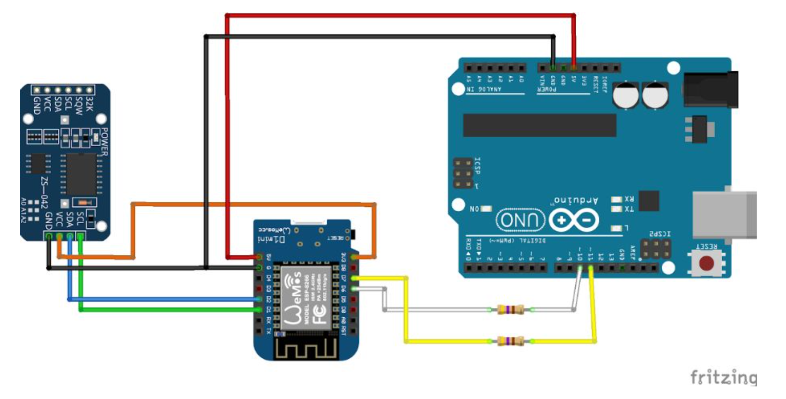

**10 Módulos com sensores de movimento e estado da iluminação principal** com comunicação sem fio RF 433 MHz instalados em residência na região do ABC. Maiores detelhes em [outro repositório do GitHub](https://github.com/vthayashi/OKIoT/tree/master/BrazilTestbed).

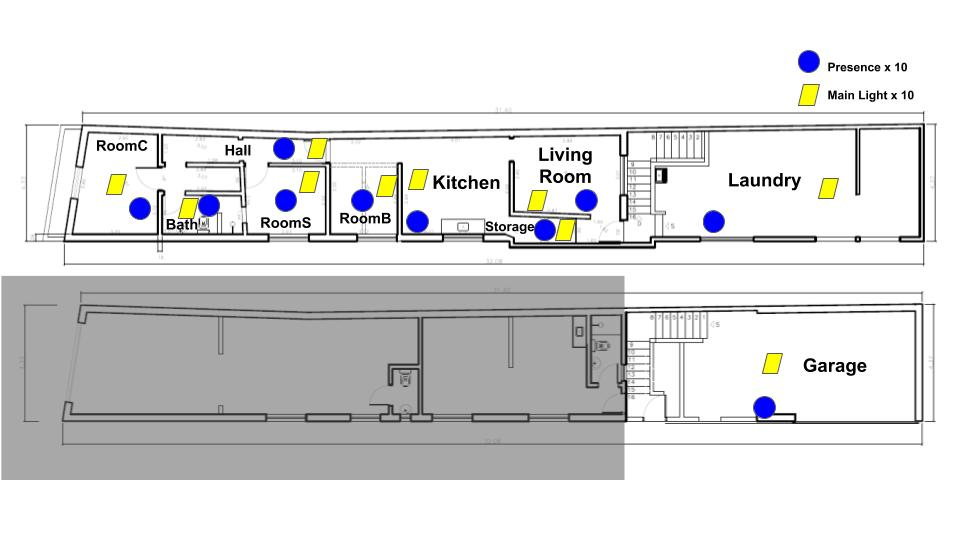

**Referência**:

HAYASHI, Victor T.; RUGGIERO, Wilson V. Non-Invasive Challenge Response Authentication for Voice Transactions with Smart Home Behavior. **Sensors**, 20(22):6563, 2020. [MDPI](https://www.mdpi.com/1424-8220/20/22/6563)

### 2.2. Dados Coletados

Dados novos coletados usando a infraestrutura anterior:

**Dados de 22 de setembro de 2020 a 21 de outubro de 2020** coletados em uma casa da região do ABC disponibilizados no [GitHub](https://github.com/vthayashi/smarthome/tree/main/datalogger).

In [829]:
import pandas as pd

def github_txt2pd_df(file):

  url = 'http://raw.githubusercontent.com/vthayashi/smarthome/main/datalogger-labeled/'

  df = pd.read_csv(url+file, sep=" ", header=None, names = ['unix_ts','room','event','state'], error_bad_lines=False)

  return df

Fazemos o teste inicial com a leitura de apenas um arquivo do formato txt a partir do github, e salvamos os dados em uma estrutura de dados do tipo dataframe da biblioteca pandas.

In [830]:
df = github_txt2pd_df('200922.txt')

df

,unix_ts,room,event,state
0,1600732834,Lavand,Som,ON
1,1600732995,Lavand,Som,OFF
2,1600733002,Lavand,Lamp,OFF
3,1600733049,Sala,TV,ON
4,1600733323,Lavand,PIR,OFF
...,...,...,...,...
1376,1600818523,Banho,Lamp,OFF
1377,1600818560,Lavand,Lamp,ON
1378,1600818561,Lavand,PIR,ON
1379,1600818932,Lavand,Lamp,OFF


In [831]:
def files2df(df, filelist):
  for file in filelist:
    print(file)
    
    df2 = github_txt2pd_df(file)
    df2

    df = pd.concat([df, df2])

  return df

Com a função definida acima, podemos obter os dados a partir de uma lista de arquivos, e salvar tudo em um mesmo dataframe:

In [832]:
filelist = ['200923.txt','200924.txt','200925.txt','200926.txt','200927.txt', \
         '200928.txt','200929.txt','200930.txt', \
         '201001.txt','201002.txt','201003.txt','201004.txt','201005.txt', \
         '201006.txt','201007.txt','201008.txt', \
         '201009.txt','201010.txt','201011.txt','201012.txt','201013.txt', \
         '201014.txt','201015.txt','201016.txt', \
         '201017.txt','201018.txt','201019.txt','201020.txt','201021.txt']

df_all = files2df(df,filelist)

df = df_all

df

200923.txt
200924.txt
200925.txt
200926.txt
200927.txt
200928.txt
200929.txt
200930.txt
201001.txt
201002.txt
201003.txt
201004.txt
201005.txt
201006.txt
201007.txt
201008.txt
201009.txt
201010.txt
201011.txt
201012.txt
201013.txt
201014.txt
201015.txt
201016.txt
201017.txt
201018.txt
201019.txt
201020.txt
201021.txt


,unix_ts,room,event,state
0,1600732834,Lavand,Som,ON
1,1600732995,Lavand,Som,OFF
2,1600733002,Lavand,Lamp,OFF
3,1600733049,Sala,TV,ON
4,1600733323,Lavand,PIR,OFF
...,...,...,...,...
801,1603324714,QuaSabr,PIR,ON
802,1603324727,Sala,PIR,ON
803,1603324732,QuaVic,PIR,ON
804,1603324771,Ver:,DataLogger4_191103a,NaN


Podemos observar que temos mais de 27 mil eventos coletados.

## 3. Pré-processamento

Nesta seção, iremos filtrar os eventos mais frequentes, e obter alguns parâmetros de interesse a partir do carimbo de tempo dos eventos.

### 3.1. Tratamento de Eventos

Começamos obtendo uma visão geral do dataframe.

In [833]:
import numpy as np

In [834]:
df.describe(exclude=[np.number])

,room,event,state
count,27117,27078,21025
unique,20,1814,2
top,RFRX,PIR,ON
freq,5236,15565,10674


In [835]:
df.head()

,unix_ts,room,event,state
0,1600732834,Lavand,Som,ON
1,1600732995,Lavand,Som,OFF
2,1600733002,Lavand,Lamp,OFF
3,1600733049,Sala,TV,ON
4,1600733323,Lavand,PIR,OFF


Obtemos uma coluna de evento com descrição completa a partir de outras colunas já existentes no dataframe:

In [836]:
df["full_event"] = df["room"]+df["event"]+df["state"]

df

,unix_ts,room,event,state,full_event
0,1600732834,Lavand,Som,ON,LavandSomON
1,1600732995,Lavand,Som,OFF,LavandSomOFF
2,1600733002,Lavand,Lamp,OFF,LavandLampOFF
3,1600733049,Sala,TV,ON,SalaTVON
4,1600733323,Lavand,PIR,OFF,LavandPIROFF
...,...,...,...,...,...
801,1603324714,QuaSabr,PIR,ON,QuaSabrPIRON
802,1603324727,Sala,PIR,ON,SalaPIRON
803,1603324732,QuaVic,PIR,ON,QuaVicPIRON
804,1603324771,Ver:,DataLogger4_191103a,NaN,NaN


Filtramos os eventos que não tem relação com dados dos sensores, como logs de instabilidade de conexão por exemplo:

In [837]:
df = df.dropna()

df = df.drop(columns=['state'])

df

,unix_ts,room,event,full_event
0,1600732834,Lavand,Som,LavandSomON
1,1600732995,Lavand,Som,LavandSomOFF
2,1600733002,Lavand,Lamp,LavandLampOFF
3,1600733049,Sala,TV,SalaTVON
4,1600733323,Lavand,PIR,LavandPIROFF
...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF
800,1603324656,Sala,PIR,SalaPIROFF
801,1603324714,QuaSabr,PIR,QuaSabrPIRON
802,1603324727,Sala,PIR,SalaPIRON


Desta forma, de 27 mil eventos, obtemos cerca de 21 mil eventos válidos.

Obtemos a visão geral dos dados novamente, em forma tabular e gráfica.

In [838]:
df.describe(exclude=[np.number])

,room,event,full_event
count,21025,21025,21025
unique,11,8,52
top,Sala,PIR,SalaPIRON
freq,3855,15565,1683


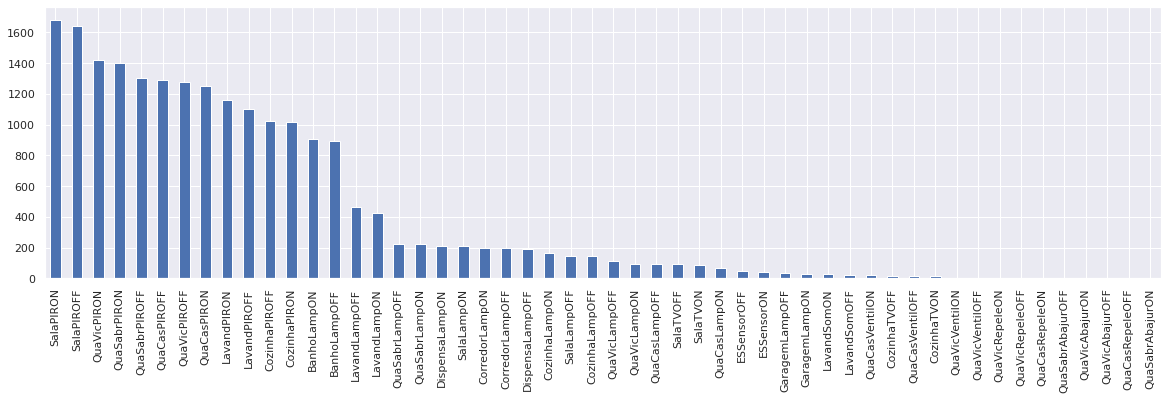

In [839]:
df['full_event'].value_counts().plot(kind='bar', figsize=(20, 5))

Realizamos o filtro de eventos mais frequentes para facilitar o aprendizado não supervisionado em seguida.

São considerados eventos frequentes aqueles com contagem maior que 800 na série de 30 dias de dados.

In [840]:
counts = df['full_event'].value_counts()

remove_list = counts[counts <= 800].index

remove_list

Index(['LavandLampOFF', 'LavandLampON', 'QuaSabrLampOFF', 'QuaSabrLampON',
       'DispensaLampON', 'SalaLampON', 'CorredorLampON', 'CorredorLampOFF',
       'DispensaLampOFF', 'CozinhaLampON', 'SalaLampOFF', 'CozinhaLampOFF',
       'QuaVicLampOFF', 'QuaVicLampON', 'QuaCasLampOFF', 'SalaTVOFF',
       'SalaTVON', 'QuaCasLampON', 'ESSensorOFF', 'ESSensorON',
       'GaragemLampOFF', 'GaragemLampON', 'LavandSomON', 'LavandSomOFF',
       'QuaCasVentilON', 'CozinhaTVOFF', 'QuaCasVentilOFF', 'CozinhaTVON',
       'QuaVicVentilON', 'QuaVicVentilOFF', 'QuaVicRepeleON',
       'QuaVicRepeleOFF', 'QuaCasRepeleON', 'QuaSabrAbajurOFF',
       'QuaVicAbajurON', 'QuaVicAbajurOFF', 'QuaCasRepeleOFF',
       'QuaSabrAbajurON'],
      dtype='object')

In [841]:
df.replace(remove_list, np.nan, inplace = True)

df

,unix_ts,room,event,full_event
0,1600732834,Lavand,Som,NaN
1,1600732995,Lavand,Som,NaN
2,1600733002,Lavand,Lamp,NaN
3,1600733049,Sala,TV,NaN
4,1600733323,Lavand,PIR,LavandPIROFF
...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF
800,1603324656,Sala,PIR,SalaPIROFF
801,1603324714,QuaSabr,PIR,QuaSabrPIRON
802,1603324727,Sala,PIR,SalaPIRON


In [842]:
df = df.dropna()

df

,unix_ts,room,event,full_event
4,1600733323,Lavand,PIR,LavandPIROFF
5,1600733447,Sala,PIR,SalaPIROFF
6,1600733941,Sala,PIR,SalaPIRON
7,1600734243,Sala,PIR,SalaPIROFF
8,1600735100,Sala,PIR,SalaPIRON
...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF
800,1603324656,Sala,PIR,SalaPIROFF
801,1603324714,QuaSabr,PIR,QuaSabrPIRON
802,1603324727,Sala,PIR,SalaPIRON


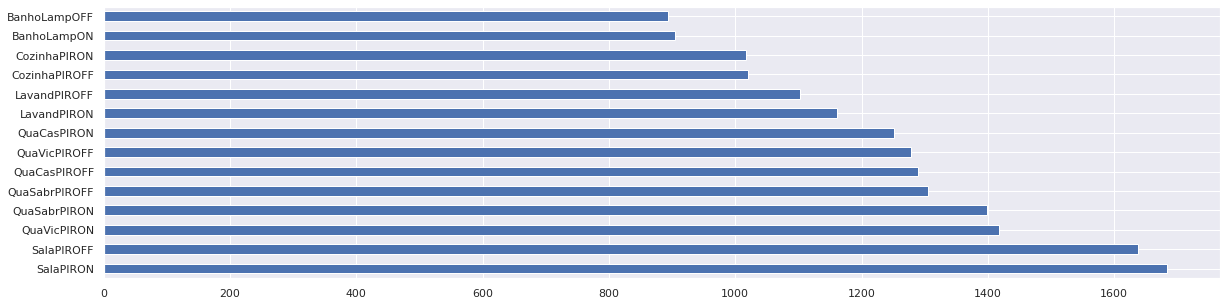

In [843]:
df['full_event'].value_counts().plot(kind='barh', figsize=(20, 5))

Desta forma, de 21 mil eventos válidos, obtemos cerca de 17 mil eventos mais frequentes.

### 3.2. Tratamento de Timestamp

Agora que tratamos os eventos, iremos obter parâmetros de interesse a partir dos carimbos de tempo presentes no dataframe.

In [844]:
df.head()

,unix_ts,room,event,full_event
4,1600733323,Lavand,PIR,LavandPIROFF
5,1600733447,Sala,PIR,SalaPIROFF
6,1600733941,Sala,PIR,SalaPIRON
7,1600734243,Sala,PIR,SalaPIROFF
8,1600735100,Sala,PIR,SalaPIRON


Conversão de unix timestamp para o formato datetime do Python:

In [845]:
df['date'] = pd.to_datetime(df['unix_ts'],unit='s')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Obtenção de parâmetro de dia da semana:

In [846]:
df['weekDay'] = df['date'].dt.day_name()

df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unix_ts,room,event,full_event,date,weekDay
4,1600733323,Lavand,PIR,LavandPIROFF,2020-09-22 00:08:43,Tuesday
5,1600733447,Sala,PIR,SalaPIROFF,2020-09-22 00:10:47,Tuesday
6,1600733941,Sala,PIR,SalaPIRON,2020-09-22 00:19:01,Tuesday
7,1600734243,Sala,PIR,SalaPIROFF,2020-09-22 00:24:03,Tuesday
8,1600735100,Sala,PIR,SalaPIRON,2020-09-22 00:38:20,Tuesday
...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,2020-10-21 23:56:41,Wednesday
800,1603324656,Sala,PIR,SalaPIROFF,2020-10-21 23:57:36,Wednesday
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,2020-10-21 23:58:34,Wednesday
802,1603324727,Sala,PIR,SalaPIRON,2020-10-21 23:58:47,Wednesday


Obtenção de parâmetro de hora do evento:

In [847]:
df['hour'] = df['date'].dt.hour

df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unix_ts,room,event,full_event,date,weekDay,hour
4,1600733323,Lavand,PIR,LavandPIROFF,2020-09-22 00:08:43,Tuesday,0
5,1600733447,Sala,PIR,SalaPIROFF,2020-09-22 00:10:47,Tuesday,0
6,1600733941,Sala,PIR,SalaPIRON,2020-09-22 00:19:01,Tuesday,0
7,1600734243,Sala,PIR,SalaPIROFF,2020-09-22 00:24:03,Tuesday,0
8,1600735100,Sala,PIR,SalaPIRON,2020-09-22 00:38:20,Tuesday,0
...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,2020-10-21 23:56:41,Wednesday,23
800,1603324656,Sala,PIR,SalaPIROFF,2020-10-21 23:57:36,Wednesday,23
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,2020-10-21 23:58:34,Wednesday,23
802,1603324727,Sala,PIR,SalaPIRON,2020-10-21 23:58:47,Wednesday,23


Obtenção de período do dia:

In [848]:
#https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe

def f(x):
    if (x > 4) and (x <= 8):
        return 'EarlyMorning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'LateNight'

In [849]:
df['dayPeriod'] = df['hour'].apply(f)

df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unix_ts,room,event,full_event,date,weekDay,hour,dayPeriod
4,1600733323,Lavand,PIR,LavandPIROFF,2020-09-22 00:08:43,Tuesday,0,LateNight
5,1600733447,Sala,PIR,SalaPIROFF,2020-09-22 00:10:47,Tuesday,0,LateNight
6,1600733941,Sala,PIR,SalaPIRON,2020-09-22 00:19:01,Tuesday,0,LateNight
7,1600734243,Sala,PIR,SalaPIROFF,2020-09-22 00:24:03,Tuesday,0,LateNight
8,1600735100,Sala,PIR,SalaPIRON,2020-09-22 00:38:20,Tuesday,0,LateNight
...,...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,2020-10-21 23:56:41,Wednesday,23,Night
800,1603324656,Sala,PIR,SalaPIROFF,2020-10-21 23:57:36,Wednesday,23,Night
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,2020-10-21 23:58:34,Wednesday,23,Night
802,1603324727,Sala,PIR,SalaPIRON,2020-10-21 23:58:47,Wednesday,23,Night


Exclusão da coluna adicional de carimbo de tempo com formato datetime:

In [850]:
df = df.drop(columns=['date'])

df

,unix_ts,room,event,full_event,weekDay,hour,dayPeriod
4,1600733323,Lavand,PIR,LavandPIROFF,Tuesday,0,LateNight
5,1600733447,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight
6,1600733941,Sala,PIR,SalaPIRON,Tuesday,0,LateNight
7,1600734243,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight
8,1600735100,Sala,PIR,SalaPIRON,Tuesday,0,LateNight
...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,Wednesday,23,Night
800,1603324656,Sala,PIR,SalaPIROFF,Wednesday,23,Night
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,Wednesday,23,Night
802,1603324727,Sala,PIR,SalaPIRON,Wednesday,23,Night


Visão geral a partir do agrupamento dos dados por dia da semana, e período do dia:

In [851]:
grouped = df.groupby(['weekDay', 'dayPeriod'])[['full_event']].count()

grouped

full_event
weekDay   dayPeriod               
Friday    EarlyMorning         319
          Eve                  398
          LateNight            439
          Morning              530
          Night                284
          Noon                 401
Monday    EarlyMorning         407
          Eve                  306
          LateNight            442
          Morning              533
          Night                292
          Noon                 429
Saturday  EarlyMorning         293
          Eve                  421
          LateNight            438
          Morning              443
          Night                266
          Noon                 383
Sunday    EarlyMorning         350
          Eve                  293
          LateNight            504
          Morning              518
          Night                241
          Noon                 384
Thursday  EarlyMorning         362
          Eve                  331
          LateNight            453
          Morning              492
          Night                226
          Noon                 362
Tuesday   EarlyMorning         497
          Eve                  440
          LateNight            594
          Morning              572
          Night                356
          Noon                 447
Wednesday EarlyMorning         435
          Eve                  471
          LateNight            599
          Morning              606
          Night                320
          Noon                 487

### 3.3. One-Hot Encoding

Nesta seção, aplicamos o One-hot encoding para preparar um dataframe que o algoritmo de aprendizado não-supervisionado K Means possa ser adotado em seção posterior.

In [852]:
df

,unix_ts,room,event,full_event,weekDay,hour,dayPeriod
4,1600733323,Lavand,PIR,LavandPIROFF,Tuesday,0,LateNight
5,1600733447,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight
6,1600733941,Sala,PIR,SalaPIRON,Tuesday,0,LateNight
7,1600734243,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight
8,1600735100,Sala,PIR,SalaPIRON,Tuesday,0,LateNight
...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,Wednesday,23,Night
800,1603324656,Sala,PIR,SalaPIROFF,Wednesday,23,Night
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,Wednesday,23,Night
802,1603324727,Sala,PIR,SalaPIRON,Wednesday,23,Night


One-hot encoding com a varíavel de evento completo:

In [853]:
onehotdf_evt = pd.get_dummies(df['full_event'], prefix='evt')

onehotdf_evt

,evt_BanhoLampOFF,evt_BanhoLampON,evt_CozinhaPIROFF,evt_CozinhaPIRON,evt_LavandPIROFF,evt_LavandPIRON,evt_QuaCasPIROFF,evt_QuaCasPIRON,evt_QuaSabrPIROFF,evt_QuaSabrPIRON,evt_QuaVicPIROFF,evt_QuaVicPIRON,evt_SalaPIROFF,evt_SalaPIRON
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0,0,0,0,1,0,0,0,0,0,0,0,0,0
800,0,0,0,0,0,0,0,0,0,0,0,0,1,0
801,0,0,0,0,0,0,0,0,0,1,0,0,0,0
802,0,0,0,0,0,0,0,0,0,0,0,0,0,1


One-hot encoding com a variável de dia da semana:

In [854]:
onehotdf_weekday = pd.get_dummies(df['weekDay'], prefix='wkday')

onehotdf_weekday

,wkday_Friday,wkday_Monday,wkday_Saturday,wkday_Sunday,wkday_Thursday,wkday_Tuesday,wkday_Wednesday
4,0,0,0,0,0,1,0
5,0,0,0,0,0,1,0
6,0,0,0,0,0,1,0
7,0,0,0,0,0,1,0
8,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
798,0,0,0,0,0,0,1
800,0,0,0,0,0,0,1
801,0,0,0,0,0,0,1
802,0,0,0,0,0,0,1


In [855]:
onehotdf_dayPeriod = pd.get_dummies(df['dayPeriod'], prefix='dayprd')

onehotdf_dayPeriod

,dayprd_EarlyMorning,dayprd_Eve,dayprd_LateNight,dayprd_Morning,dayprd_Night,dayprd_Noon
4,0,0,1,0,0,0
5,0,0,1,0,0,0
6,0,0,1,0,0,0
7,0,0,1,0,0,0
8,0,0,1,0,0,0
...,...,...,...,...,...,...
798,0,0,0,0,1,0
800,0,0,0,0,1,0
801,0,0,0,0,1,0
802,0,0,0,0,1,0


In [856]:
df_onehot = pd.concat([onehotdf_evt, onehotdf_weekday, onehotdf_dayPeriod], axis = 1, join = 'inner')

df_onehot

,evt_BanhoLampOFF,evt_BanhoLampON,evt_CozinhaPIROFF,evt_CozinhaPIRON,evt_LavandPIROFF,evt_LavandPIRON,evt_QuaCasPIROFF,evt_QuaCasPIRON,evt_QuaSabrPIROFF,evt_QuaSabrPIRON,evt_QuaVicPIROFF,evt_QuaVicPIRON,evt_SalaPIROFF,evt_SalaPIRON,wkday_Friday,wkday_Monday,wkday_Saturday,wkday_Sunday,wkday_Thursday,wkday_Tuesday,wkday_Wednesday,dayprd_EarlyMorning,dayprd_Eve,dayprd_LateNight,dayprd_Morning,dayprd_Night,dayprd_Noon
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
800,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
801,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
802,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


Neste momento, temos um dataframe (df) com veriáveis categóricas, e outro dataframe com variáveis numéricas (df_onehot).

## 4. Algoritmo de Aprendizado Não-supervisionado

Nesta seção, são aplicados dois algoritmos para agrupamento dos dados de eventos.

### 4.1. K Modes

O algoritmo K Modes é usado para agrupamento de variáveis categóricas.

**Referência**:

HUANG, Zhexue; NG, Michael K. A fuzzy k-modes algorithm for clustering categorical data. **IEEE transactions on Fuzzy Systems**, v. 7, n. 4, p. 446-452, 1999.

A biblioteca usada está disponível no GitHub.

**Referência**:

VOS, Nelis J. kmodes categorical clustering library. Disponível em: https://github.com/nicodv/kmodes. Acesso em 18 de novembro de 2020.

In [857]:
!pip install kmodes

In [858]:
import numpy as np
from kmodes.kmodes import KModes

Utilizamos apenas os parâmetros de ambiente em que o evento ocorreu, e o período do dia:

In [859]:
df2 = df.drop(columns=['unix_ts','hour','weekDay','full_event','event'])

df2

,room,dayPeriod
4,Lavand,LateNight
5,Sala,LateNight
6,Sala,LateNight
7,Sala,LateNight
8,Sala,LateNight
...,...,...
798,Lavand,Night
800,Sala,Night
801,QuaSabr,Night
802,Sala,Night


Consideramos apenas 10 clusters por simplicidade:

In [860]:
km = KModes(n_clusters=10, init='Huang', n_init=10, verbose=0)

clusters = km.fit_predict(df2)
centroids = km.cluster_centroids_
km_df = pd.DataFrame(centroids)

print(' ')
print(centroids)
df['kmode'] = km.labels_

 
[['QuaCas' 'EarlyMorning']
 ['Lavand' 'Morning']
 ['Sala' 'Eve']
 ['Lavand' 'Eve']
 ['QuaSabr' 'Morning']
 ['Banho' 'LateNight']
 ['Sala' 'Noon']
 ['Lavand' 'Noon']
 ['QuaCas' 'Noon']
 ['Sala' 'Night']]


O resultado da rotulagem com o modelo K Modes está agregado ao dataframe: 

In [861]:
df

,unix_ts,room,event,full_event,weekDay,hour,dayPeriod,kmode
4,1600733323,Lavand,PIR,LavandPIROFF,Tuesday,0,LateNight,1
5,1600733447,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight,2
6,1600733941,Sala,PIR,SalaPIRON,Tuesday,0,LateNight,2
7,1600734243,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight,2
8,1600735100,Sala,PIR,SalaPIRON,Tuesday,0,LateNight,2
...,...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,Wednesday,23,Night,1
800,1603324656,Sala,PIR,SalaPIROFF,Wednesday,23,Night,9
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,Wednesday,23,Night,4
802,1603324727,Sala,PIR,SalaPIRON,Wednesday,23,Night,9


Visualização de contagem de eventos nos clusters para uma análise qualitativa:

In [862]:
def cluster(i,column):
  words = []

  for index, row in df.iterrows():
    if (row[column] == i):
      words.append(row['full_event']+' '+row['weekDay']+' '+row['dayPeriod'])

  cluster = Counter(words).most_common(20)

  rst = pd.DataFrame(cluster,
                    columns=['Event', 'Frequency']).set_index('Event')

  rst.plot.barh(rot=0, figsize=(10,5), width=0.8)

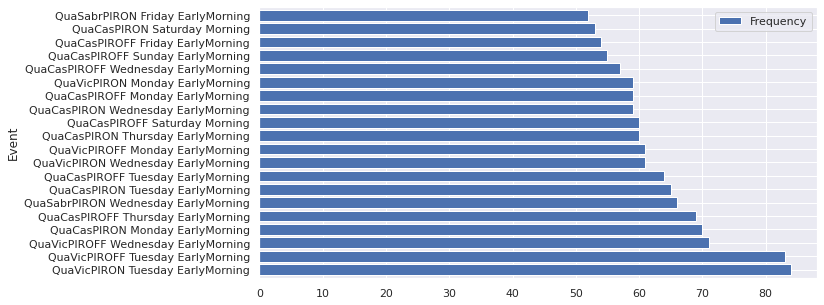

In [863]:
cluster(0,'kmode')

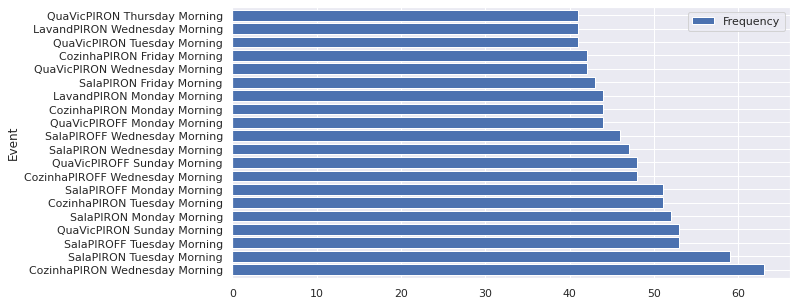

In [864]:
cluster(1,'kmode')

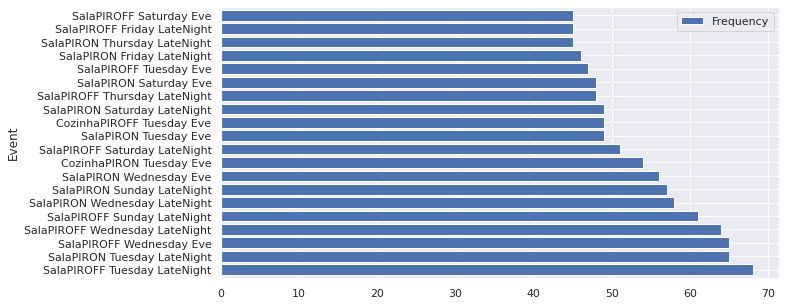

In [865]:
cluster(2,'kmode')

Em geral, observamos que os clusters possuem o mesmo período do dia, ou pelo menos períodos próximos.

Contudo, observado o gráfico abaixo da série temporal com os dados rotulados, nao podemos obeservar qualquer periodicidade, o que seria algo desejável para aprendizado de atividade diária.

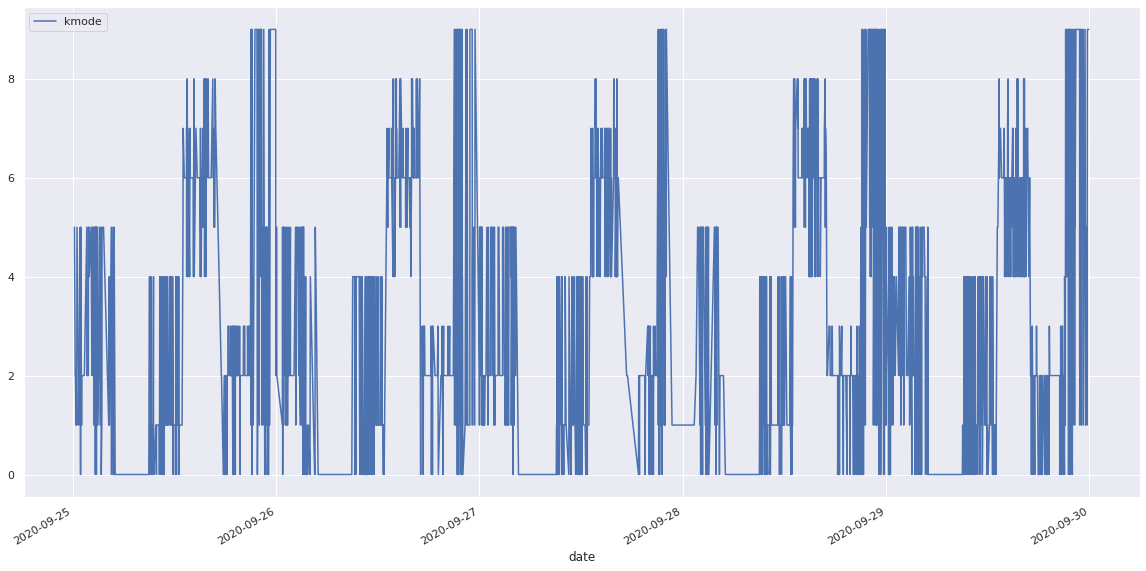

In [866]:
df['date'] = pd.to_datetime(df['unix_ts'],unit='s')

df3 = df[1600992503 < df.unix_ts]

df3 = df3[df3.unix_ts < 1601424031]

df3 = df3.set_index('date')

df3 = df3.drop(columns=['hour','dayPeriod','weekDay','full_event','unix_ts','room','event'])

df3.plot(figsize=(20,10))

### 4.2. K Means

O segundo algoritmo de clusterização é o K Means, de 1967.

Para mais detalhes: https://github.com/vthayashi/curso-fiot/blob/patch-2/5-tratamentodedados/opcoes/k-means.md

**Referência**:

MACQUEEN, James et al. Some methods for classification and analysis of multivariate observations. In: **Proceedings of the fifth Berkeley symposium on mathematical statistics and probability**. 1967. p. 281-297.

In [867]:
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

Utilizamos variáveis numéricas do dataframe obtido com o one-hot encoding:

In [868]:
df_onehot

,evt_BanhoLampOFF,evt_BanhoLampON,evt_CozinhaPIROFF,evt_CozinhaPIRON,evt_LavandPIROFF,evt_LavandPIRON,evt_QuaCasPIROFF,evt_QuaCasPIRON,evt_QuaSabrPIROFF,evt_QuaSabrPIRON,evt_QuaVicPIROFF,evt_QuaVicPIRON,evt_SalaPIROFF,evt_SalaPIRON,wkday_Friday,wkday_Monday,wkday_Saturday,wkday_Sunday,wkday_Thursday,wkday_Tuesday,wkday_Wednesday,dayprd_EarlyMorning,dayprd_Eve,dayprd_LateNight,dayprd_Morning,dayprd_Night,dayprd_Noon
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
800,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
801,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
802,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


Também consideramos 10 clusters por simplicidade:

In [869]:
kmeans = KMeans(n_clusters=10).fit(df_onehot)

df['kmean'] = kmeans.labels_
#df['kmean'].value_counts()

In [870]:
df

,unix_ts,room,event,full_event,weekDay,hour,dayPeriod,kmode,date,kmean
4,1600733323,Lavand,PIR,LavandPIROFF,Tuesday,0,LateNight,1,2020-09-22 00:08:43,9
5,1600733447,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight,2,2020-09-22 00:10:47,9
6,1600733941,Sala,PIR,SalaPIRON,Tuesday,0,LateNight,2,2020-09-22 00:19:01,9
7,1600734243,Sala,PIR,SalaPIROFF,Tuesday,0,LateNight,2,2020-09-22 00:24:03,9
8,1600735100,Sala,PIR,SalaPIRON,Tuesday,0,LateNight,2,2020-09-22 00:38:20,9
...,...,...,...,...,...,...,...,...,...,...
798,1603324601,Lavand,PIR,LavandPIROFF,Wednesday,23,Night,1,2020-10-21 23:56:41,5
800,1603324656,Sala,PIR,SalaPIROFF,Wednesday,23,Night,9,2020-10-21 23:57:36,5
801,1603324714,QuaSabr,PIR,QuaSabrPIRON,Wednesday,23,Night,4,2020-10-21 23:58:34,5
802,1603324727,Sala,PIR,SalaPIRON,Wednesday,23,Night,9,2020-10-21 23:58:47,5


Também é possível observar os eventos mais frequentes em cada cluster:

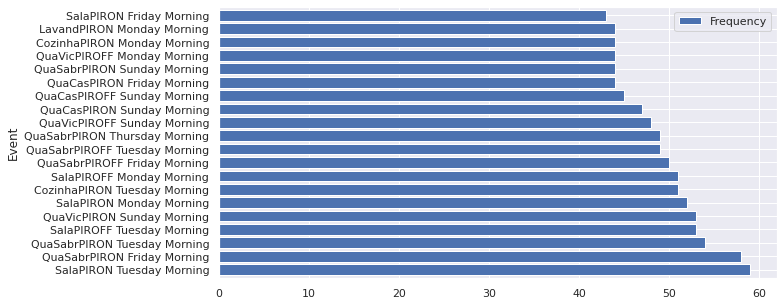

In [871]:
cluster(0,'kmean')

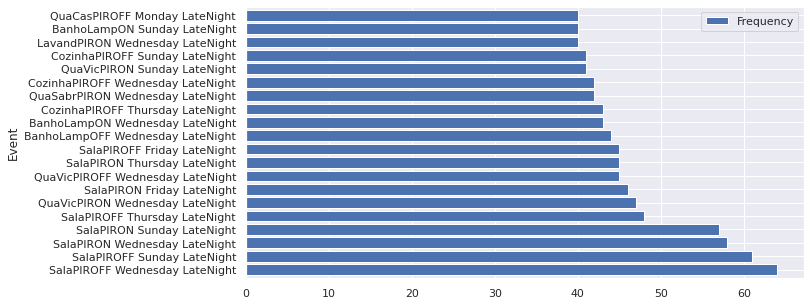

In [872]:
cluster(1,'kmean')

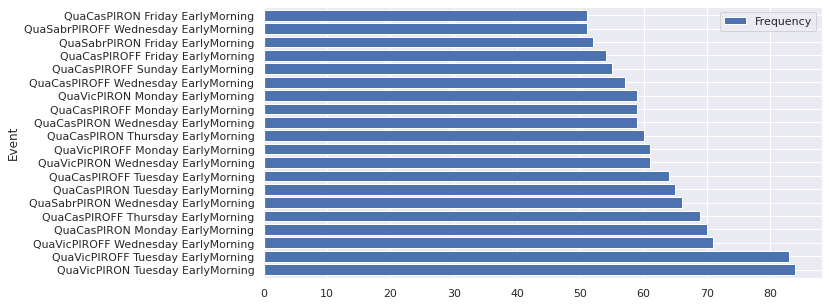

In [873]:
cluster(2,'kmean')

Em geral, temos uma concordância um pouco maior entre o período do dia dos eventos mais frequentes nos clusters.

Com a visualização de alguns dias da série de dados rotulada, podemos observar alguma periodicidade:

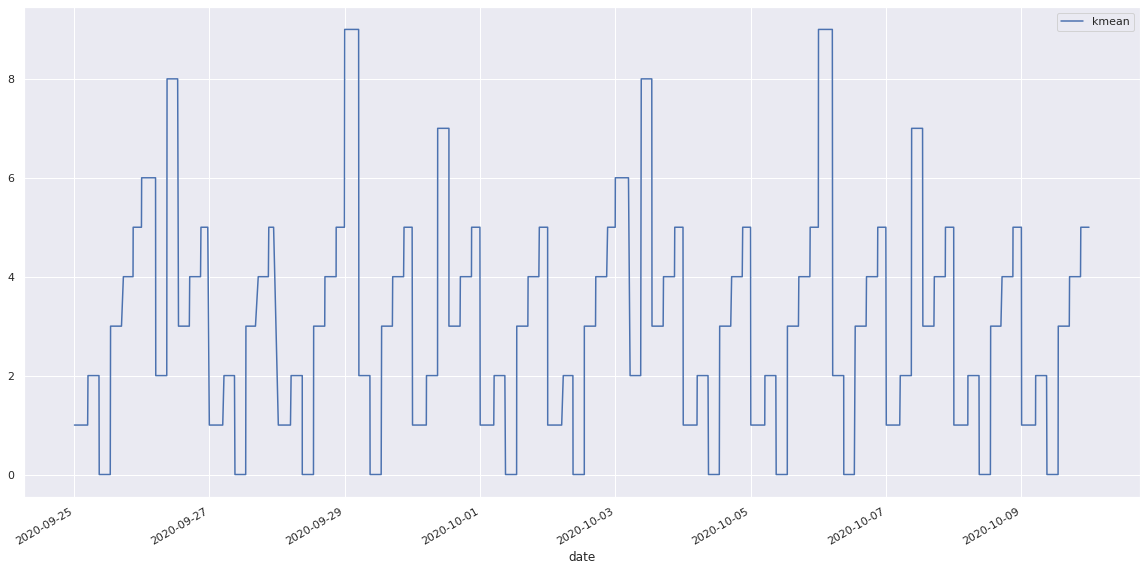

In [874]:
df['date'] = pd.to_datetime(df['unix_ts'],unit='s')

df3 = df[1600992503 < df.unix_ts]

df3 = df3[df3.unix_ts < 1602288095]

df3 = df3.set_index('date')

df3 = df3.drop(columns=['hour','dayPeriod','weekDay','full_event','unix_ts','room','event','kmode'])

df3.plot(figsize=(20,10))

Desta forma, optamos pelos dados rotulados pelo modelo K-Means.

## 5. InterSCity

Nesta etapa, os dados rotulados são enviados à plataforma [InterSCity](https://interscity.org/), através de API disponível.

**Referência**:

BATISTA, Daniel Macêdo et al. Interscity: Addressing future internet research challenges for smart cities. In: **2016 7th International Conference on the Network of the Future (NOF)**. IEEE, 2016. p. 1-6.

### 5.1. Setup

In [901]:
!pip install requests

In [886]:
import requests
import json

Referência: https://colab.research.google.com/drive/1xCmWAMgn5iC3_STBF723kzqm0ev_tn2q

Dados de uma casa conectada agrupados com algoritmo K Means.

In [878]:
df['date'] = pd.to_datetime(df['unix_ts'],unit='s')

df4 = df.drop(columns=['hour','dayPeriod','weekDay','full_event','unix_ts','kmode','event','room'])

df4

,date,kmean
4,2020-09-22 00:08:43,9
5,2020-09-22 00:10:47,9
6,2020-09-22 00:19:01,9
7,2020-09-22 00:24:03,9
8,2020-09-22 00:38:20,9
...,...,...
798,2020-10-21 23:56:41,5
800,2020-10-21 23:57:36,5
801,2020-10-21 23:58:34,5
802,2020-10-21 23:58:47,5


In [882]:
dates = df4.date.tolist()

dates[0]

Timestamp('2020-09-22 00:08:43')

In [883]:
values = df4.kmean.tolist()

values[0]

9

Configurações iniciais para uso da API do InterSCity:

In [887]:
# Endereço para a api
api = 'http://api.playground.interscity.org'

Criação de capability de um sensor inteligente com atividade diária:

In [888]:
# Cria uma 'capability'

# Playground - Resource Catalog - Post - Catalog capabilities

capability_json = {
  "name": "ativ_casa",
  "description": "Dados de uma casa conectada agrupados com algoritmo K Means",
  "capability_type": "sensor"
}
r = requests.post(api+'/catalog/capabilities/', json=capability_json)
if(r.status_code == 201):
  content = json.loads(r.text)
  print(json.dumps(content, indent=2, sort_keys=True))
else:
  print('Status code: '+str(r.status_code))

{
  "capability_type": "sensor",
  "description": "Dados de uma casa conectada agrupados com algoritmo K Means",
  "id": 1201,
  "name": "ativ_casa"
}


In [889]:
# Exibe as 'capabilities'

# Playground - Resource Catalog - Get - Catalog capabilities

r = requests.get(api+'/catalog/capabilities')
if(r.status_code == 200):
  content = json.loads(r.text)
  print(json.dumps(content, indent=2, sort_keys=True))
else:
  print('Status code: '+str(r.status_code))

{
  "capabilities": [
    {
      "description": "Mede a tensao utilizando em Voltes",
      "function": 0,
      "id": 1037,
      "name": "tensao2_Smarmita"
    },
    {
      "description": "Measure the temperature of the environment",
      "function": 0,
      "id": 969,
      "name": "temperature2"
    },
    {
      "description": "Mede a temperatura do ambiente",
      "function": 0,
      "id": 971,
      "name": "temperatura 2"
    },
    {
      "description": "Mede a temperatura do ambiente em graus Celsius",
      "function": 0,
      "id": 970,
      "name": "temperatura"
    },
    {
      "description": "Mede a Energia Ativa Total em Watts",
      "function": 0,
      "id": 1038,
      "name": "EAtivaTotal"
    },
    {
      "description": "Measure the temperature of the environment",
      "function": 0,
      "id": 972,
      "name": "temperature3"
    },
    {
      "description": "Measure the temperature of the environment",
      "function": 0,
      "id": 973,
  

Criação de um resource de casa conectada:

In [892]:
# Cria um 'resource'

# Playground - Resource Catalog - Post - Catalog resource

resource_json = {
  "data": {
    "description": "Casa Conectada",
    "capabilities": [
      "ativ_casa"
    ],
    "status": "active",
    "lat": -23.6665574,
    "lon": -46.5100398
  }
}
r = requests.post(api+'/catalog/resources', json=resource_json)
uuid = ''
if(r.status_code == 201):
  resource = json.loads(r.text)
  uuid = resource['data']['uuid']
  print(json.dumps(resource, indent=2))
else:
  print('Status code: '+str(r.status_code))

{
  "data": {
    "id": 1210,
    "uri": null,
    "created_at": "2020-11-18T18:40:03.701Z",
    "updated_at": "2020-11-18T18:40:03.701Z",
    "lat": -23.6665574,
    "lon": -46.5100398,
    "status": "active",
    "collect_interval": null,
    "description": "Casa Conectada",
    "uuid": "77b32027-97ac-4dac-9a92-90c45aca635c",
    "city": null,
    "neighborhood": null,
    "state": null,
    "postal_code": null,
    "country": null,
    "capabilities": [
      "ativ_casa"
    ]
  }
}


In [893]:
# Exibe os 'resources'

# Playground - Resource Catalog - Get - Catalog resource

r = requests.get(api+'/catalog/resources')
if(r.status_code == 200):
  content = json.loads(r.text)
  print(json.dumps(content, indent=2, sort_keys=True))
else:
  print('Status code: '+str(r.status_code))

{
  "resources": [
    {
      "capabilities": [
        "ativ_casa"
      ],
      "city": null,
      "collect_interval": null,
      "country": null,
      "created_at": "2020-11-18T18:40:03.701Z",
      "description": "Casa Conectada",
      "id": 1210,
      "lat": -23.6665574,
      "lon": -46.5100398,
      "neighborhood": null,
      "postal_code": null,
      "state": null,
      "status": "active",
      "updated_at": "2020-11-18T18:40:03.701Z",
      "uri": null,
      "uuid": "77b32027-97ac-4dac-9a92-90c45aca635c"
    },
    {
      "capabilities": [
        "temperatura"
      ],
      "city": null,
      "collect_interval": null,
      "country": null,
      "created_at": "2020-11-17T00:53:27.401Z",
      "description": "Onibus publico",
      "id": 1209,
      "lat": -23.559616,
      "lon": -46.731386,
      "neighborhood": null,
      "postal_code": null,
      "state": null,
      "status": "active",
      "updated_at": "2020-11-17T00:53:27.401Z",
      "uri": null,
 

### 5.2. Adicionar Dados

Teste inicial com dois dados:

In [896]:
# Adiciona dado da 'capability' ao 'resource'

# Playground - Resource Adaptor - Post - Adaptor resources

capability_data_json = {
  "data": [
    {
      "ativ_casa": values[0],
      "timestamp": dates[0].isoformat()
    },
    {
      "ativ_casa": values[1],
      "timestamp": dates[1].isoformat()
    }
  ]
}
r = requests.post(api+'/adaptor/resources/'+uuid+'/data/environment_monitoring', json=capability_data_json)
if(r.status_code == 201):
  print('Ok')
else:
  print('Status code: '+str(r.status_code))

Ok


Resultado após teste inicial com dois dados:

In [897]:
# Exibe dados do 'resource'

# Playground - Data collector - Post - Resources data

r = requests.post(api+'/collector/resources/'+uuid+'/data')
if(r.status_code == 200):
  content = json.loads(r.text)
  print(json.dumps(content, indent=2, sort_keys=True))
else:
  print('Status code: '+str(r.status_code))

{
  "resources": [
    {
      "capabilities": {
        "environment_monitoring": [
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:08:43.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:10:47.000Z"
          }
        ]
      },
      "uuid": "77b32027-97ac-4dac-9a92-90c45aca635c"
    }
  ]
}


Após o teste inicial com dois dados, fazemos o envio da série de dados rotulados completa através da API do InterSCity.

In [898]:
#https://stackoverflow.com/questions/25348640/two-lists-to-json-format-in-python

[{'ativ_casa': value, 'timestamp': date.isoformat()} for value, date in zip(values, dates)]

[{'ativ_casa': 9, 'timestamp': '2020-09-22T00:08:43'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:10:47'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:19:01'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:24:03'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:38:20'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:38:51'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:40:30'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:43:21'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:43:22'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:43:31'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:48:54'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T00:50:55'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:01:01'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:03:41'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:06:03'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:07:43'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:12:51'},
 {'ativ_casa': 9, 'timestamp': '2020-09-22T01:19:06'},
 {'ativ_ca

In [899]:
# Adiciona dado da 'capability' ao 'resource'

# Playground - Resource Adaptor - Post - Adaptor resources

capability_data_json = {
  "data": [{'ativ_casa': value, 'timestamp': date.isoformat()} for value, date in zip(values, dates)]
}
r = requests.post(api+'/adaptor/resources/'+uuid+'/data/environment_monitoring', json=capability_data_json)
if(r.status_code == 201):
  print('Ok')
else:
  print('Status code: '+str(r.status_code))

Ok


Resultado com a série completa:

In [900]:
# Exibe dados do 'resource'

# Playground - Data collector - Post - Resources data

r = requests.post(api+'/collector/resources/'+uuid+'/data')
if(r.status_code == 200):
  content = json.loads(r.text)
  print(json.dumps(content, indent=2, sort_keys=True))
else:
  print('Status code: '+str(r.status_code))

{
  "resources": [
    {
      "capabilities": {
        "environment_monitoring": [
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:08:43.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:10:47.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:08:43.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:19:01.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:10:47.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:38:20.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:38:51.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:24:03.000Z"
          },
          {
            "ativ_casa": 9,
            "date": "2020-09-22T00:43:22.000Z"
          },
          {
   

## 6. Conclusão

### 6.1. Considerações Finais

* A partir de dados reais coletados (22 de setembro de 2020 a 21 de outubro de 2020) em testbed de casa conectada na região do ABC, foi possível realizar o **pré-processamento, agrupamento de dados com algoritmos de aprendizado não-supervisionado, e integração destes dados agrupados com a API da InterSCity**;
* Todos os dados e código estão disponíveis no **GitHub**: https://github.com/vthayashi/smarthome;
* O pré-processamento integrou **One-Hot Encoding**, preparação de parâmetros de **dia da semana** e **período do dia**, e consideração apenas dos **eventos mais frequentes** (que ocorreram pelo menos 800 vezes na série completa);
* O algoritmo **K Means** obteve melhor resultado que o algoritmo K Modes para esta tarefa de agrupamento de eventos de movimentação e estado da iluminação da casa conectada.



### 6.2. Trabalhos Futuros

*   Incluir eventos de energia a partir de dados coletados de [smart meter](https://github.com/vthayashi/smarthome/tree/main/smartmeter) para aprendizado de atividade diária
*   Fazer análise com dados de longo prazo e avaliar viabilidade de **autenticação continuada**